# Atom Analysis Notebook, first take PGC image then take two probeimage, with a microwave pi pulse before each of them

### features: have a general way of analysising the data, independent of the number of picture taking and the number of atoms in the camera view

##vertical runs, atomLocation = [wellIndicator-1,1]

29 four aotms 200 rep, 5 points 11 9 6 4
30 single atom at  6

### Initialize Constants

In [201]:
%matplotlib inline
date = "160817";
#fileName = "TestTSV";
wellIndicator = [6, 4];
accumulations = 200;
# Zero-indexed!!!
atomLocation = [[wellIndicator[i]-1,1] for i in range(len(wellIndicator))] # assuming vertical orientation
#atomLocation = [1, wellIndicator-1];
picturesPerExperiment = 2;
#imageProbeNum = [1,2]
imagePGCNum = [0]
atomPeakGuess = 400;
EMgain = 5 # for this analysis only PGC #200 #3.97/200*11.4
countoffset = 89;
run_num = 29

In [202]:
### Uninteresting stuff.
# Data is saved as "data.fits" files
from astropy.io import fits
import numpy as np
np.set_printoptions(threshold=np.nan)
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize
import math
import scipy.special
import itertools # for multiple variables in one for loop

%run fitfunctions
dataRepositoryPath = "\\\\andor\\share\\Data and documents\\Data repository\\";
todaysDataPath = dataRepositoryPath + date + "\\Raw Data\\data_" + str(run_num) + ".fits";
keyPath = dataRepositoryPath + date + "\\Raw Data\\key_" + str(run_num) + ".txt"
# todaysDataPath = dataRepositoryPath + date + "\\data.fits";
# keyPath = dataRepositoryPath + "Key_file\\key.txt"

### Load Key File

In [203]:
key = np.array([]);
with open(keyPath) as keyFile:
    for line in keyFile:
        key = np.append(key, float(line.strip('\n')))
#key

### Load Fits File & Get Dimensions

In [204]:
# Get the array from the fits file. That's all I care about.
fitsInfo = (fits.open(todaysDataPath, "append"));
rawData = fitsInfo[0].data;
# the .shape member of an array gives an array of the dimesnions of the array.
numberOfPictures = rawData.shape[0]; 
numberOfExperiments = int(numberOfPictures / picturesPerExperiment) 
horizontalImageDimension = rawData.shape[1]; verticalImageDimension = rawData.shape[2];

### Initial Data Analysis

threshold = [ 87.  69.]


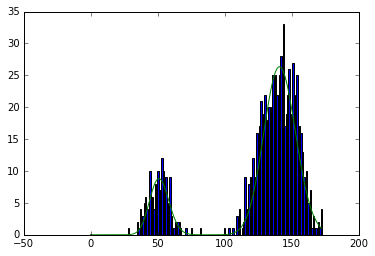

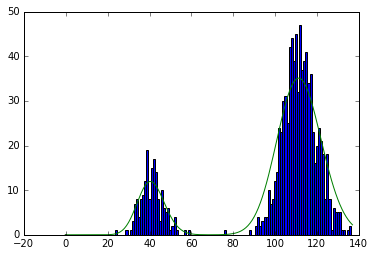

In [205]:
backGnd = []
peakData = []
fitVals = np.zeros((picturesPerExperiment,4))
#threshold = np.zeros((len(atomLocation),picturesPerExperiment)) # here the PGC threshold is reaaly just from the initial image
threshold = np.zeros(len(atomLocation)) # here the PGC threshold is reaaly just from the initial image
backGnd = [np.array([1/4*(rawData[imageInc][0][0] + rawData[imageInc][horizontalImageDimension-1][verticalImageDimension-1] 
                             + rawData[imageInc][0][verticalImageDimension-1] + \
                          rawData[imageInc][horizontalImageDimension-1][0]) \
           for imageInc in range(ipicturesPerExperiment, numberOfPictures, picturesPerExperiment)]) \
           for ipicturesPerExperiment in range(0, picturesPerExperiment)]
peakData = [[np.array([(rawData[imageInc][atomLocation[atomLoci][0]][atomLocation[atomLoci][1]]- countoffset)/EMgain
           for imageInc in range(ipicturesPerExperiment, numberOfPictures, picturesPerExperiment)]) \
           for ipicturesPerExperiment in range(0, picturesPerExperiment)] \
           for atomLoci in range(len(atomLocation)) ] # peakData[0] corresponds to the atomLocation[0]

binlength = 1
bins = [[np.array(range(0,int(max(peakData[atomLoci][ipicturesPerExperiment])),binlength)) \
        for ipicturesPerExperiment in range(0, picturesPerExperiment)] \
        for atomLoci in range(len(atomLocation)) ] 

experimentDataBinned = \
    [[np.histogram(peakData[atomLoci][ipicturesPerExperiment], bins=bins[atomLoci][ipicturesPerExperiment])[0] \
        for ipicturesPerExperiment in range(0, picturesPerExperiment)] \
        for atomLoci in range(len(atomLocation)) ] 

for atomLoci in range(len(atomLocation)):
    for ind in imagePGCNum:
        plt.figure()
        plt.hist(peakData[atomLoci][ind], bins=range(0,int(max(peakData[atomLoci][ind])),1), align='left')
        #np.argsort()[-1] finds the max index
        guessPt1 = np.argsort(experimentDataBinned[atomLoci][ind])[-1]
        ampPt1tpm = np.e**(-guessPt1)
        for j in np.array(range(int(guessPt1))):
                ampPt1tpm = ampPt1tpm*guessPt1/(j+1)
        ampPt1 = experimentDataBinned[atomLoci][ind][guessPt1]/ampPt1tpm
        guessPt2 =  np.argsort(experimentDataBinned[atomLoci][ind] -\
                               Poissonfunc(bins[atomLoci][ind][0:-1],guessPt1, ampPt1*2))[-1]
        ampPt2tpm = np.e**(-guessPt2)
        for j in np.array(range(int(guessPt2))):
            ampPt2tpm = ampPt2tpm*guessPt2/(j+1)
        ampPt2 = experimentDataBinned[atomLoci][ind][guessPt2]/ampPt2tpm
        [guessPtHigh, guessAmpHigh, guessPtLow, guessAmpLow] = [guessPt1, ampPt1, guessPt2, ampPt2] if guessPt1 > guessPt2 \
                                                else [guessPt2, ampPt2, guessPt1, ampPt1]
        #print([guessHigh, ampHigh, guessLow, ampLow ])
        guess = [guessPtLow, guessAmpLow, guessPtHigh, guessAmpHigh]
        #guess = [10, 200, guessPtHigh, guessAmpHigh]
        #print(guess)
        fitVals[ind], dummy = scipy.optimize.curve_fit(Poissonfunc2, bins[atomLoci][ind][0:-1], \
                                                       experimentDataBinned[atomLoci][ind], guess);
        plt.plot(bins[atomLoci][ind][0:-1],Poissonfunc2(bins[atomLoci][ind][0:-1], \
                                                           fitVals[ind][0],fitVals[ind][1],fitVals[ind][2],fitVals[ind][3]));
        threshold[atomLoci] = min(int(fitVals[ind][0]),int(fitVals[ind][2]))+\
            np.argsort(Poissonfunc2(bins[atomLoci][ind]\
            [min(int(fitVals[ind][0]),int(fitVals[ind][2])):max(int(fitVals[ind][0]),int(fitVals[ind][2]))],\
                                fitVals[ind][0],fitVals[ind][1],fitVals[ind][2],fitVals[ind][3]))[0]
    #print(fitVals)
print('threshold =',threshold)



<Container object of 3 artists>

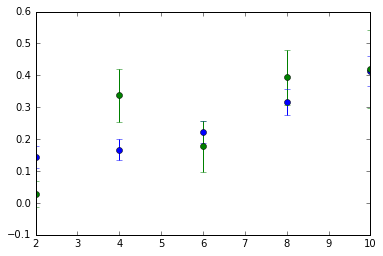

In [211]:
bright = []
loaded = []
for atomLoci in range(len(atomLocation)):
    loaded.append( np.array(peakData[atomLoci][0] > threshold[atomLoci]) )
    bright.append( np.array(peakData[atomLoci][1] > threshold[atomLoci]) )

loadedAll = loaded[0] # ini the list for loaded all atoms in each well
for atomLoci in range(1,len(atomLocation)):
    loadedAll = loadedAll & loaded[atomLoci]  # getting the events that loaded 4 atoms do not use &=

loadedAllthenBright = []
loadedAllthenBright_list = []
loadedAllthenBright_err_list = []
for atomLoci in range(len(atomLocation)):
    loadedAllthenBright_tmp = np.array(loadedAll & bright[atomLoci]) +0 # converting from Boolean to numbers
    loadedAllthenBright.append(loadedAllthenBright_tmp) # reading from the second PGC
    loadedAllthenBright_list_tmp = [] # ini the list with axis as the key
    loadedAllthenBright_list_err_tmp = [] # ini the list with axis as the key
    for keyi in range(len(key)):
        tmp_denom = np.sum(loadedAll[keyi*accumulations:(keyi+1)*accumulations])
        tmp = np.sum(loadedAllthenBright_tmp[keyi*accumulations:(keyi+1)*accumulations])/ tmp_denom         
        loadedAllthenBright_list_tmp.append(tmp)
        loadedAllthenBright_list_err_tmp.append(np.sqrt(tmp*(1-tmp)/tmp_denom))
    loadedAllthenBright_list.append(loadedAllthenBright_list_tmp)
    loadedAllthenBright_err_list.append(loadedAllthenBright_list_err_tmp)

#plt.figure()
#plt.plot(key, np.array(loadedAllthenBright_list[1])+np.array(loadedAllthenBright_list[0]))

#plt.figure()
#plt.errorbar(key, loadedAllthenBright_list[0], yerr=loadedAllthenBright_err_list[0], fmt='o')  

#plt.figure()
#plt.errorbar(key, loadedAllthenBright_list[1], yerr=loadedAllthenBright_err_list[1], fmt='o')    

plt.figure()
plt.errorbar(key, np.array(loadedAllthenBright_list[0])+np.array(loadedAllthenBright_list[1]),\
             yerr=np.sqrt(np.array(loadedAllthenBright_err_list[0])**2+np.array(loadedAllthenBright_err_list[0])**2)\
                          , fmt='o')  
#+\np.array(loadedAllthenBright_list[2])+np.array(loadedAllthenBright_list[3])

loadedSinglethenBright = []
loadedSinglethenBright_list = []
loadedSinglethenBright_err_list = []
loadedSingle_tmp = []
loadedSingle = []
for atomLoci in range(len(atomLocation)):
    loadedSingle_tmp = loaded[atomLoci]
    for atomLocii in range(len(atomLocation)):
        if atomLocii != atomLoci:
            loadedSingle_tmp = loadedSingle_tmp & (1-loaded[atomLocii]) # exclude events that other site is loaded
            #print(np.sum(loadedSingle_tmp))
    loadedSingle.append(loadedSingle_tmp)
    loadedSinglethenBright_tmp = np.array(loadedSingle_tmp & bright[atomLoci])
    loadedSinglethenBright.append(loadedSinglethenBright_tmp)
    loadedSinglethenBright_list_tmp = [] # ini the list with axis as the key
    loadedSinglethenBright_list_err_tmp = [] # ini the list with axis as the key
    for keyi in range(len(key)):
        tmp_denom = np.sum(loadedSingle_tmp[keyi*accumulations:(keyi+1)*accumulations])
        tmp = np.sum(loadedSinglethenBright_tmp[keyi*accumulations:(keyi+1)*accumulations])/tmp_denom
        loadedSinglethenBright_list_tmp.append(tmp)
        loadedSinglethenBright_list_err_tmp.append(np.sqrt(tmp*(1-tmp)/tmp_denom))
    loadedSinglethenBright_list.append(loadedSinglethenBright_list_tmp)
    loadedSinglethenBright_err_list.append(loadedSinglethenBright_list_err_tmp)

#plt.figure()
plt.errorbar(key, np.array(loadedSinglethenBright_list[0])+np.array(loadedSinglethenBright_list[1]),\
             yerr=np.sqrt(np.array(loadedSinglethenBright_err_list[0])**2+np.array(loadedSinglethenBright_err_list[0])**2)\
                          , fmt='o')    
#np.array(loadedSinglethenBright_list[2])+np.array(loadedSinglethenBright_list[3])

#plt.figure()
#plt.errorbar(key, loadedSinglethenBright_list[0], yerr=loadedSinglethenBright_err_list[0], fmt='o')  

#plt.figure()
#plt.errorbar(key, loadedSinglethenBright_list[1], yerr=loadedSinglethenBright_err_list[1], fmt='o')    

In [207]:
np.sum(loadedSingle)

272

In [208]:
np.sum(loadedAll)

693